In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GB, 
    GradientBoostingClassifier as GC)
from ISLP.bart import BART
import sklearn.model_selection as skm
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [3]:
#IMPORT DATA
data = pd.read_pickle("data.pkl")

In [4]:
##CONVERT DATA TO ARRAY
y = data["callback"] 
covariates = ["type_1", "type_2", "type_3", "type_4","female", "public_facing","ba_quality","language_skills","exp_highquality","ma","certificate"] 
X = data[covariates] 
x_names = list(X.columns)

In [5]:
## CREATE TRAINING AND VALIDATION DATA SPLIT
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)

In [6]:
# BALANCED TRAINING SET
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0, stratify=y
)

# OVERSAMPLE CLASS 1 TO BALANCE DATA
ros = RandomOverSampler(random_state=0)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("Original training class distribution:\n", y_train.value_counts())
print("Balanced training class distribution:\n", y_train_bal.value_counts())

Original training class distribution:
 callback
0    4448
1     501
Name: count, dtype: int64
Balanced training class distribution:
 callback
0    4448
1    4448
Name: count, dtype: int64


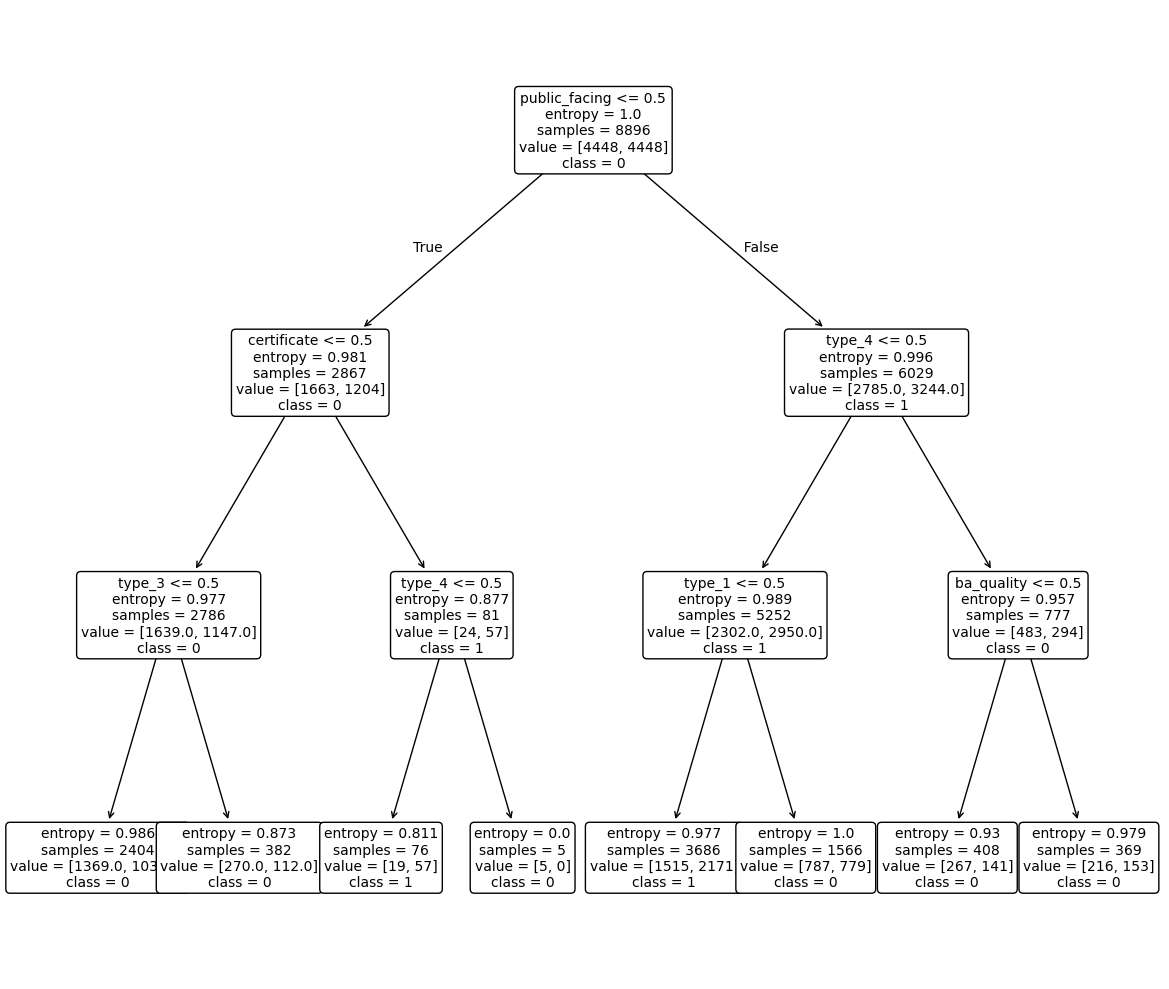

In [7]:
## ---- TREE REGRESSION ---- ##
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X_train_bal, y_train_bal)

#Predict
y_prob_clf = clf.predict_proba(X_test)
y_pred_clf = clf.predict(X_test)


#Error Measurements
clf_logloss = log_loss(y_test, y_prob_clf)
clf_acc = accuracy_score(y_test, y_pred_clf)
clf_prec = precision_score(y_test, y_pred_clf)
clf_rec = recall_score(y_test, y_pred_clf)
clf_f1 = f1_score(y_test, y_pred_clf)
clf_cm = confusion_matrix(y_test, y_pred_clf)

##PLOT
plt.figure(figsize=(12, 10))

plot_tree(
    clf,
    feature_names=x_names,
    class_names=[str(c) for c in clf.classes_],
    rounded=True,
    fontsize=10,           

plt.tight_layout()        
plt.savefig("reg_tree.png", dpi=200, bbox_inches='tight') 
plt.show()

In [8]:
## ---- BAGGING ---- ##
bagging = RF(max_features=X_train.shape[1], random_state=0,
            max_depth=4, n_estimators = 1500)
bagging.fit(X_train_bal, y_train_bal)

#Predict y
y_prob_bag = bagging.predict_proba(X_test)
y_pred_bag = bagging.predict(X_test)

#Error Measurements
bag_logloss = log_loss(y_test, y_prob_bag)
bag_acc = accuracy_score(y_test, y_pred_bag)
bag_prec = precision_score(y_test, y_pred_bag)
bag_rec = recall_score(y_test, y_pred_bag)
bag_f1 = f1_score(y_test, y_pred_bag)
bag_cm = confusion_matrix(y_test, y_pred_bag)

In [9]:
## ---- RANDOM FOREST ---- ##
#Fit the tree
RF_clf = RF(max_features=3,
               random_state=0,
               max_depth=4,
               n_estimators=1500).fit(X_train_bal, y_train_bal)

#Predict y 
y_prob_RF = RF_clf.predict_proba(X_test)
y_pred_RF = RF_clf.predict(X_test)

#Error Measurements
rf_logloss = log_loss(y_test, y_prob_RF)
rf_acc = accuracy_score(y_test, y_pred_RF)
rf_prec = precision_score(y_test, y_pred_RF)
rf_rec = recall_score(y_test, y_pred_RF)
rf_f1 = f1_score(y_test, y_pred_RF)
rf_cm = confusion_matrix(y_test, y_pred_RF)

In [10]:
## FEATURE IMPORTANCE CHART
feature_imp = pd.DataFrame(
    {'importance':RF_clf.feature_importances_},
    index=x_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
public_facing,0.295826
type_4,0.272223
female,0.063997
type_1,0.063174
ma,0.058016
type_3,0.054402
certificate,0.053823
language_skills,0.051508
ba_quality,0.042519
exp_highquality,0.028999


C:\Users\agonz\AppData\Local\Temp\ipykernel_51212\995977496.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


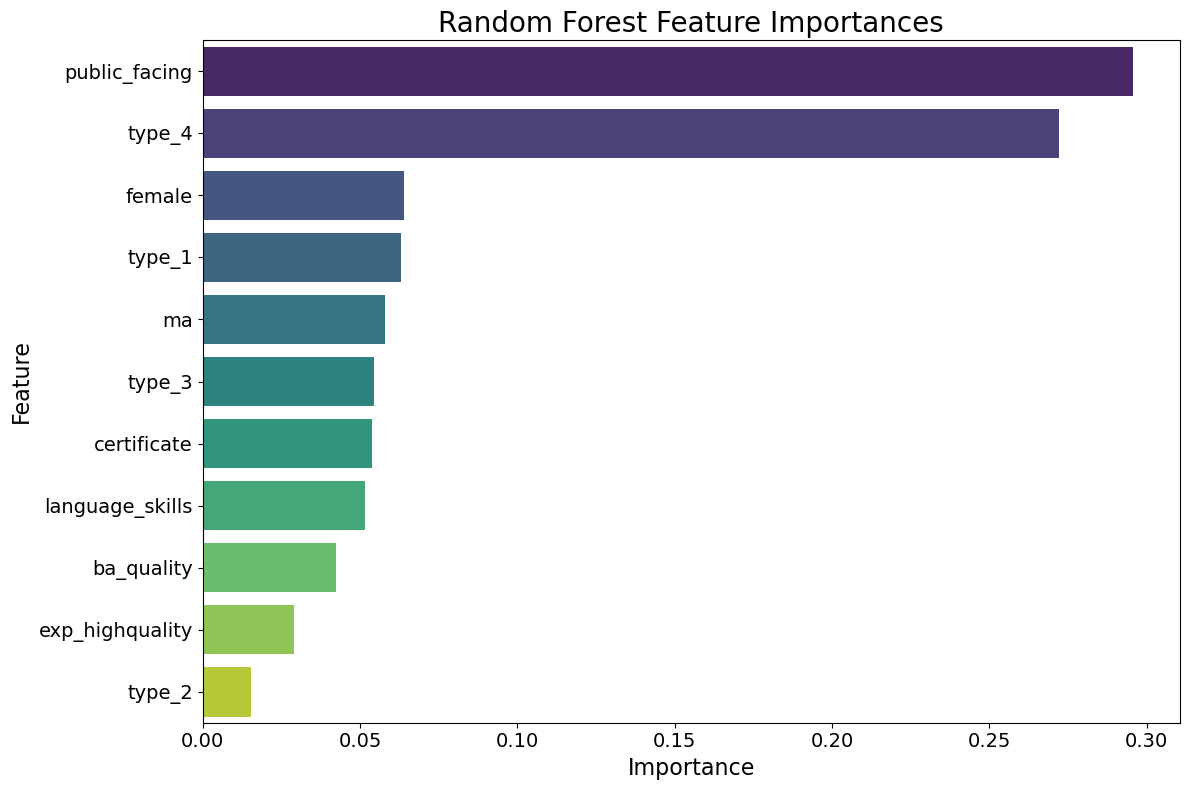

In [11]:
## FEATURE IMPORTANCE PLOT
feature_importances = pd.Series(RF_clf.feature_importances_, index=X_train.columns)

# Sort importances descending
feature_importances = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=feature_importances.values,
    y=feature_importances.index,
    palette="viridis"
)

# --- Titles and labels ---
plt.title("Random Forest Feature Importances", fontsize=20)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# ---  Increase tick label font sizes explicitly ---
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig("importance_matrix.png", dpi=200, bbox_inches='tight')
plt.show()

In [12]:
## ---- GRADIENT BOOSTING ---- ##
boosting = GC(n_estimators=1500,
                   learning_rate=0.001,
                   max_depth=4,
                   random_state=0)
boosting.fit(X_train_bal, y_train_bal)

#Predict y 
y_prob_boost = boosting.predict_proba(X_test)
y_pred_boost = boosting.predict(X_test)

#Error Measurements
boost_logloss = log_loss(y_test, y_prob_boost)
boost_acc = accuracy_score(y_test, y_pred_boost)
boost_prec = precision_score(y_test, y_pred_boost)
boost_rec = recall_score(y_test, y_pred_boost)
boost_f1 = f1_score(y_test, y_pred_boost)
boost_cm = confusion_matrix(y_test, y_pred_boost)

In [13]:
## ---- CV Comparison ---- ##
# Create a dataframe
results = {
    "Model": ["Tree Classifier", "Random Forest", "Bagging", "Boosting"],
    "Log-Loss": [clf_logloss, rf_logloss, bag_logloss, boost_logloss],
    "Accuracy": [clf_acc, rf_acc, bag_acc, boost_acc],
    "Precision": [clf_prec, rf_prec, bag_prec, boost_prec],
    "Recall": [clf_rec, rf_rec, bag_rec, boost_rec],
    "F1": [clf_f1, rf_f1, bag_f1, boost_f1]
}

# Convert to DataFrame
error_measurements = pd.DataFrame(results)

error_measurements.to_latex(
    "cv_comparison.tex",       # filename
    index=False,               # no row numbers
    caption="Comparison of Cross-Validation Metrics Across Models",
    float_format="%.3f",
    column_format="lccccc"
)
